In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, List
import warnings

In [4]:
# Global configurations
code_directory = '/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/code'
os.chdir(code_directory)
base_path_results = '../results'

In [26]:
def inspect_region_features():
        
    # Load data
    print("Loading data...")
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Print basic information
    print("\nDataset Overview:")
    print("=" * 50)
    print(f"HUP Region Features shape: {hup_region_features.shape}")
    print(f"MNI Region Features shape: {mni_region_features.shape}")
    
    # Inspect columns
    print("\nColumns in datasets:")
    print("=" * 50)
    print("HUP columns:", hup_region_features.columns.tolist())
    print("MNI columns:", mni_region_features.columns.tolist())
    
    # Feature columns (excluding metadata columns)
    feature_columns = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean',
        'entropy_1min_mean',
        'entropy_fullts_mean'
    ]
    
    # Analyze patient and region coverage
    print("\nPatient and Region Coverage:")
    print("=" * 50)
    print("HUP Dataset:")
    print(f"Number of unique patients: {hup_region_features['patient_id'].nunique()}")
    print(f"Number of unique regions: {hup_region_features['roi'].nunique()}")
    print("\nMNI Dataset:")
    print(f"Number of unique patients: {mni_region_features['patient_id'].nunique()}")
    print(f"Number of unique regions: {mni_region_features['roi'].nunique()}")
    
    # Analyze common regions
    common_regions = set(hup_region_features['roi'].unique()) & set(mni_region_features['roi'].unique())
    print(f"\nNumber of common regions between datasets: {len(common_regions)}")
    
    # Feature statistics by region
    print("\nFeature Statistics by Dataset:")
    print("=" * 50)
    
    for dataset_name, dataset in [("HUP", hup_region_features), ("MNI", mni_region_features)]:
        print(f"\n{dataset_name} Dataset Feature Statistics:")
        feature_stats = dataset[feature_columns].agg(['mean', 'std', 'min', 'max'])
        print(feature_stats)
    
    # Analyze patient counts per region
    print("\nPatient Counts per Region:")
    print("=" * 50)
    
    def get_region_patient_counts(df):
        return df.groupby('roi')['patient_id'].nunique().sort_values(ascending=False)
    
    print("\nHUP Dataset - Top 10 regions by patient count:")
    print(get_region_patient_counts(hup_region_features).head(10))
    
    print("\nMNI Dataset - Top 10 regions by patient count:")
    print(get_region_patient_counts(mni_region_features).head(10))
    
    # Identify regions with low patient counts
    min_patients = 5  # Threshold for minimum patients
    
    print(f"\nRegions with <{min_patients} patients:")
    print("=" * 50)
    
    for dataset_name, dataset in [("HUP", hup_region_features), ("MNI", mni_region_features)]:
        patient_counts = get_region_patient_counts(dataset)
        low_count_regions = patient_counts[patient_counts < min_patients]
        print(f"\n{dataset_name} Dataset:")
        print(low_count_regions)
    
    # Save detailed analysis to file
    output_file = os.path.join(base_path_results, 'region_features_analysis.txt')
    print(f"\nSaving to: {output_file}")
    
    with open(output_file, 'w') as f:
        f.write("Region Features Analysis\n")
        f.write("=" * 50 + "\n\n")
        
        # Write patient counts per region
        f.write("Patient Counts per Region:\n")
        f.write("-" * 30 + "\n")
        f.write("\nHUP Dataset:\n")
        f.write(get_region_patient_counts(hup_region_features).to_string())
        f.write("\n\nMNI Dataset:\n")
        f.write(get_region_patient_counts(mni_region_features).to_string())
        
        # Write feature correlations
        f.write("\n\nFeature Correlations:\n")
        f.write("-" * 30 + "\n")
        f.write("\nHUP Dataset:\n")
        f.write(hup_region_features[feature_columns].corr().to_string())
        f.write("\n\nMNI Dataset:\n")
        f.write(mni_region_features[feature_columns].corr().to_string())

# if __name__ == "__main__":
#     inspect_region_features()

Cohen's d with bootstrap confidence intervals

# For each iteration:
1. Resample from group1 with replacement
2. Resample from group2 with replacement
3. Compute Cohen's d for these resamples
4. Store the result

# After all iterations:
5. Sort the bootstrap estimates
6. Take percentiles for confidence intervals
   - For 95% CI: 2.5th and 97.5th percentiles

In [ ]:
def compute_cohens_d(group1: np.ndarray, group2: np.ndarray) -> float:
    """
    Compute Cohen's d effect size between two groups.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
        
    Returns:
    --------
    float
        Cohen's d effect size
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_sd = np.sqrt((var1 + var2) / 2)
    
    # Mean difference
    mean_diff = np.mean(group1) - np.mean(group2)
    
    # Cohen's d
    d = mean_diff / pooled_sd if pooled_sd != 0 else 0
    
    return d

def bootstrap_cohens_d(group1: np.ndarray, group2: np.ndarray, 
                      n_iterations: int = 1000, 
                      confidence_level: float = 0.95) -> Tuple[float, Tuple[float, float]]:
    """
    Compute Cohen's d with bootstrap confidence intervals.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
    n_iterations : int
        Number of bootstrap iterations
    confidence_level : float
        Confidence level for the intervals (default: 0.95)
        
    Returns:
    --------
    Tuple[float, Tuple[float, float]]
        (Cohen's d, (lower CI, upper CI))
    """
    # Original Cohen's d
    d_orig = compute_cohens_d(group1, group2)
    
    # Bootstrap samples
    n1, n2 = len(group1), len(group2)
    d_boots = []
    
    for _ in range(n_iterations):
        boot1 = np.random.choice(group1, size=n1, replace=True)
        boot2 = np.random.choice(group2, size=n2, replace=True)
        d_boots.append(compute_cohens_d(boot1, boot2))
    
    # Compute confidence intervals
    ci_lower = np.percentile(d_boots, (1 - confidence_level) * 100 / 2)
    ci_upper = np.percentile(d_boots, 100 - (1 - confidence_level) * 100 / 2)
    
    return d_orig, (ci_lower, ci_upper)

def analyze_effect_sizes(hup_features: pd.DataFrame, 
                        mni_features: pd.DataFrame, 
                        min_patients: int = 5) -> Tuple[Dict, Dict]:
    """
    Compute Cohen's d and bootstrap CIs for all region-feature pairs.
    
    Parameters:
    -----------
    hup_features, mni_features : pd.DataFrame
        DataFrames containing features for each cohort
    min_patients : int
        Minimum number of patients required for analysis
        
    Returns:
    --------
    Tuple[Dict, Dict]
        (effect_sizes, confidence_intervals)
    """
    # Feature columns (excluding metadata)
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    # Get common regions
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    # Initialize results dictionaries
    effect_sizes = {}
    confidence_intervals = {}
    
    for region in common_regions:
        # Get patient counts for each region
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        # Skip regions with too few patients
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        effect_sizes[region] = {}
        confidence_intervals[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Compute Cohen's d and bootstrap CIs
            d, (ci_lower, ci_upper) = bootstrap_cohens_d(hup_data, mni_data)
            
            effect_sizes[region][feature] = d
            confidence_intervals[region][feature] = (ci_lower, ci_upper)
    
    return effect_sizes, confidence_intervals

In [22]:
def visualize_effect_sizes(effect_sizes: Dict, 
                           confidence_intervals: Dict,
                           output_path: str = None):
    """
    Create visualizations for effect sizes and confidence intervals.
    """
    # Convert dictionaries to DataFrame
    df_list = []
    for region in effect_sizes:
        for feature in effect_sizes[region]:
            d = effect_sizes[region][feature]
            ci_lower, ci_upper = confidence_intervals[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'Cohens_d': d,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            })

    df = pd.DataFrame(df_list)

    # Define consistent feature ordering and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]

    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }

    # 1. Heatmap of effect sizes
    plt.figure(figsize=(12, 8))

    # Rename columns for display
    heatmap_data = df.pivot(index='Region', columns='Feature', values='Cohens_d')
    # Reorder columns according to feature_order
    heatmap_data = heatmap_data[feature_order]
#     heatmap_data.columns = [
#     f"{feature_name_mapping[col]} ({freq_range})"
#     for col, freq_range in zip(feature_order, 
#                                ['0.5–4 Hz', '4–8 Hz', '8–13 Hz', '13–30 Hz', '30–80 Hz', 'Entropy (1 min)', 'Entropy (full)'])
# ]

#     # Create heatmap
#     sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, 
#                 vmin=-1.5, vmax=1.5, annot=True, fmt='.2f',
#                 xticklabels=True, yticklabels=True)

#     # Rotate x-axis labels to horizontal for better readability
#     plt.xticks(rotation=0)
#     plt.title("Cohen's d Effect Sizes: HUP vs MNI")
#     plt.tight_layout()

    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]

    # Create heatmap
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, 
                vmin=-1.5, vmax=1.5, annot=True, fmt='.2f',
                xticklabels=True, yticklabels=True)

    plt.xticks(rotation=0)
    plt.title("Cohen's d Effect Sizes: HUP vs MNI")
    plt.tight_layout()

    # Save heatmap
    if output_path:
        plt.savefig(f"{output_path}/cohens_d_effect_sizes_heatmap.png", dpi=300, bbox_inches='tight')

    # 2. Forest plot with region names and ordered features
    plt.figure(figsize=(15, 12))  # Increased figure size to accommodate region names

    # Get unique regions and create y-axis positions
    unique_regions = df['Region'].unique()
    y_positions = np.arange(len(unique_regions))

    # Create color cycle for features
    colors = plt.cm.tab10(np.linspace(0, 1, len(feature_order)))

    for idx, feature in enumerate(feature_order):
        feature_data = df[df['Feature'] == feature].copy()
        # Map regions to y-positions
        feature_data['y_pos'] = feature_data['Region'].map({region: i for i, region in enumerate(unique_regions)})

        plt.errorbar(feature_data['Cohens_d'], 
                     feature_data['y_pos'],
                     xerr=[feature_data['Cohens_d'] - feature_data['CI_lower'],
                           feature_data['CI_upper'] - feature_data['Cohens_d']],
                     fmt='o', label=feature_name_mapping[feature], 
                     alpha=0.7, color=colors[idx])

    plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    plt.xlabel("Cohen's d")
    plt.yticks(y_positions, unique_regions, fontsize=8)
    plt.title("Effect Sizes with 95% Confidence Intervals\n(Positive = Higher in HUP, Negative = Higher in MNI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save forest plot
    if output_path:
        plt.savefig(f"{output_path}/cohens_d_effect_sizes_forest.png", dpi=300, bbox_inches='tight')

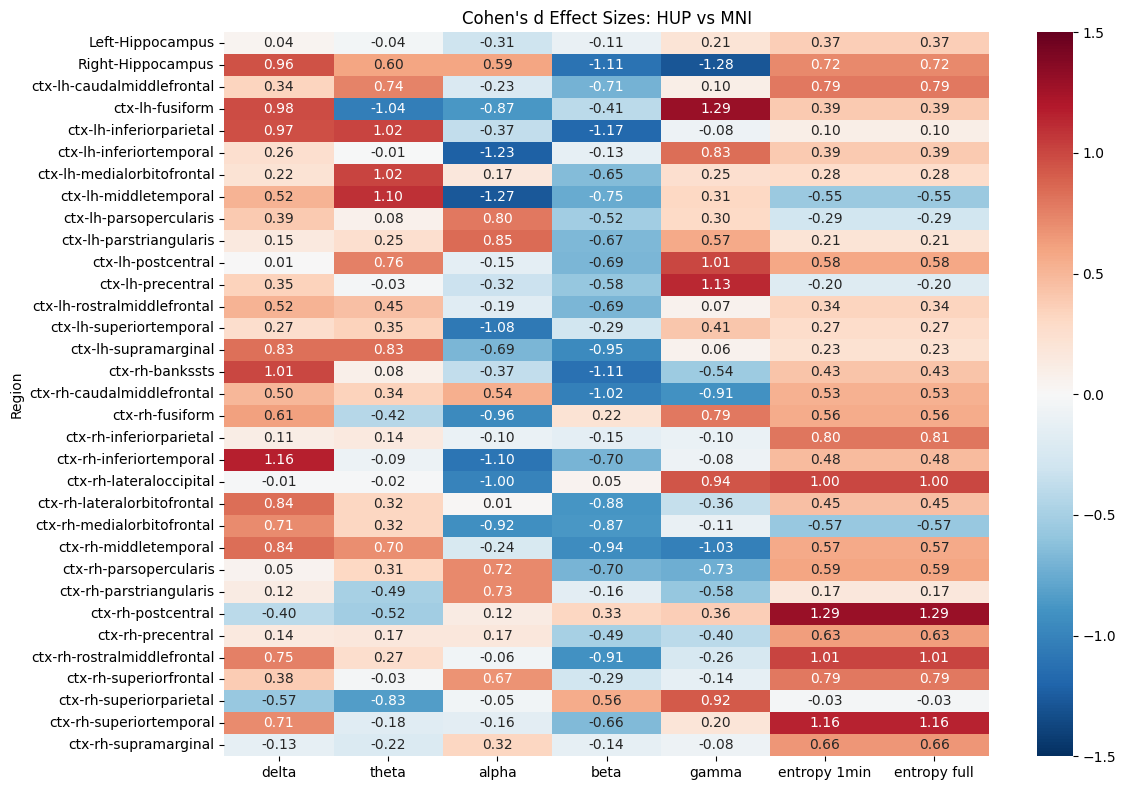

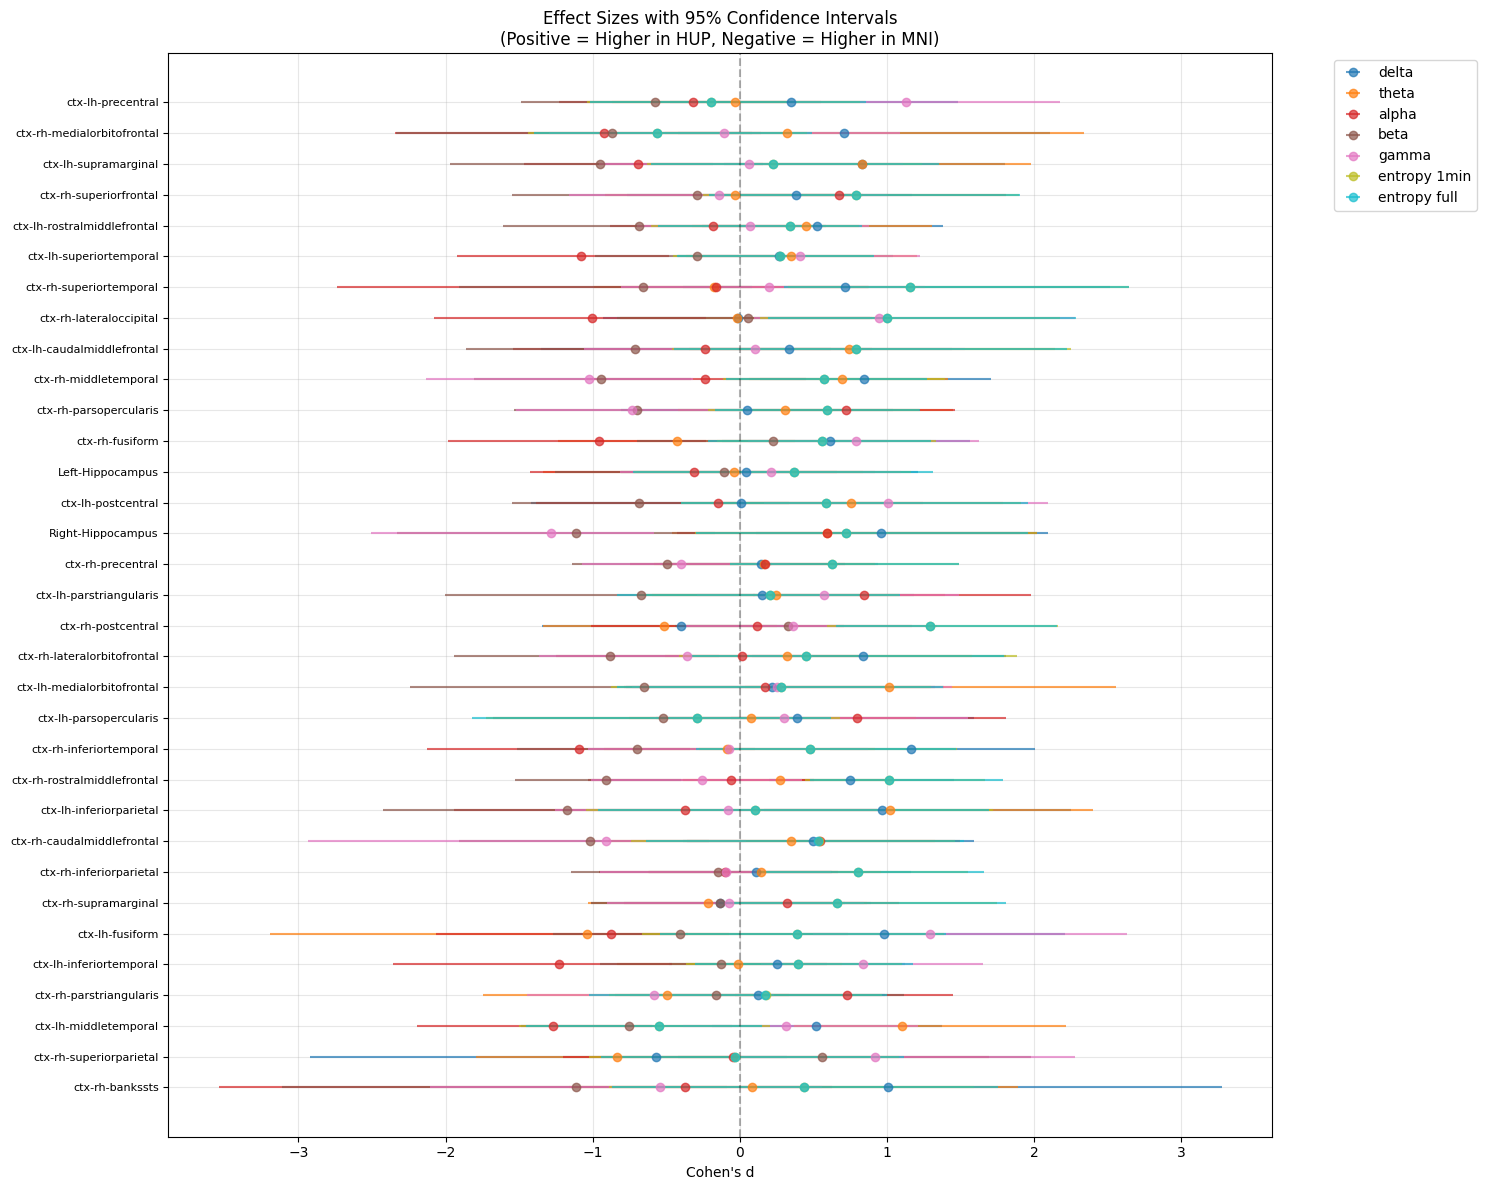

In [23]:
def main():
    """
    Main function to run the analysis.
    """
    # Load data (assuming these are already loaded as per your script)
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Compute effect sizes and confidence intervals
    effect_sizes, confidence_intervals = analyze_effect_sizes(
        hup_region_features, 
        mni_region_features,
        min_patients=5
    )
    
    # Create visualizations
    visualize_effect_sizes(
        effect_sizes, 
        confidence_intervals,
        output_path=base_path_results
    )
    
    # Save numerical results
    results_df = []
    for region in effect_sizes:
        for feature in effect_sizes[region]:
            d = effect_sizes[region][feature]
            ci_lower, ci_upper = confidence_intervals[region][feature]
            results_df.append({
                'Region': region,
                'Feature': feature,
                'Cohens_d': d,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            })
    
    results_df = pd.DataFrame(results_df)
    results_df.to_csv(os.path.join(base_path_results, 'cohens_d_results.csv'), index=False)

if __name__ == "__main__":
    main()


Normality Test Summary:
Total region-feature pairs tested: 231
Normal distributions in both cohorts: 173 (74.9%)

Potentially problematic cases (p < 0.05):
--------------------------------------------------

ctx-rh-bankssts - alphaRel_mean:
  HUP: p=0.0300 (n=6)
  MNI: p=0.4772 (n=5)

ctx-rh-superiorparietal - deltaRel_mean:
  HUP: p=0.0049 (n=5)
  MNI: p=0.0867 (n=12)

ctx-lh-middletemporal - entropy_1min_mean:
  HUP: p=0.0062 (n=15)
  MNI: p=0.7925 (n=12)

ctx-lh-middletemporal - entropy_fullts_mean:
  HUP: p=0.0063 (n=15)
  MNI: p=0.7938 (n=12)

ctx-rh-parstriangularis - alphaRel_mean:
  HUP: p=0.0144 (n=10)
  MNI: p=0.9375 (n=11)

ctx-rh-parstriangularis - betaRel_mean:
  HUP: p=0.0113 (n=10)
  MNI: p=0.4041 (n=11)

ctx-rh-parstriangularis - gammaRel_mean:
  HUP: p=0.0180 (n=10)
  MNI: p=0.8082 (n=11)

ctx-lh-fusiform - deltaRel_mean:
  HUP: p=0.0036 (n=13)
  MNI: p=0.8624 (n=6)

ctx-lh-fusiform - alphaRel_mean:
  HUP: p=0.0007 (n=13)
  MNI: p=0.7792 (n=6)

ctx-lh-fusiform - betaR

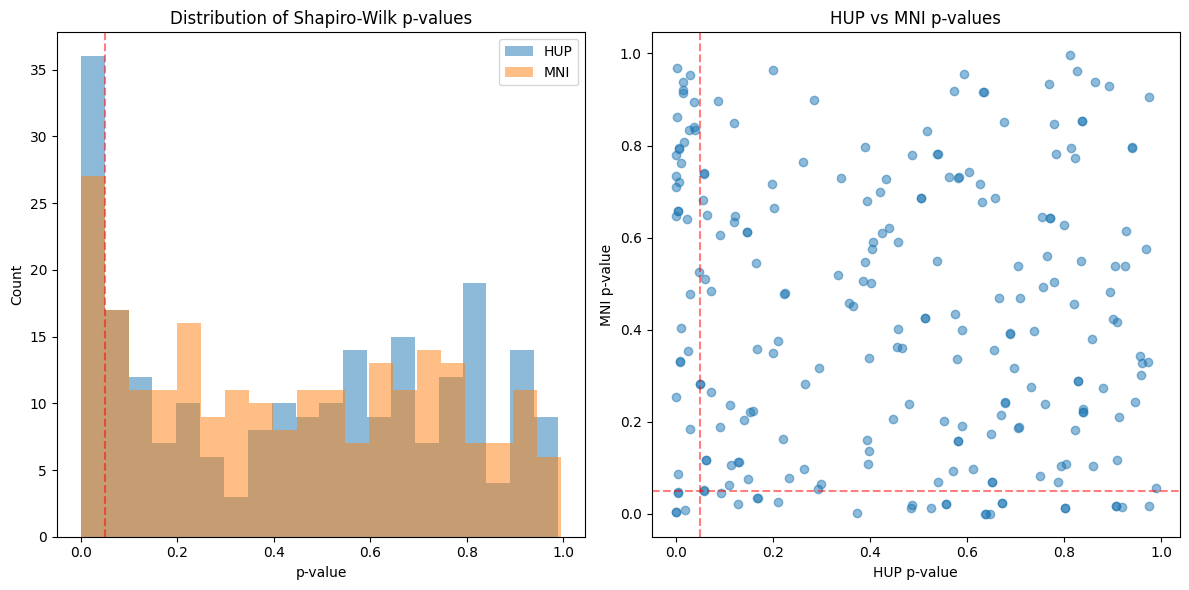

In [28]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

def check_normality_and_visualize(hup_features: pd.DataFrame, 
                                mni_features: pd.DataFrame,
                                min_patients: int = 5) -> Dict:
    """
    Check normality of features across regions for both HUP and MNI datasets.
    
    Parameters:
    -----------
    hup_features, mni_features : pd.DataFrame
        DataFrames containing features for each cohort
    min_patients : int
        Minimum number of patients required for analysis
        
    Returns:
    --------
    Dict
        Nested dictionary containing normality test results
    """
    # Feature columns (excluding metadata)
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    # Get common regions
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    # Initialize results dictionary
    normality_results = {}
    
    # Lists for summary statistics
    all_p_values_hup = []
    all_p_values_mni = []
    normal_count = 0
    total_tests = 0
    
    for region in common_regions:
        # Get patient counts
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        # Skip regions with too few patients
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        normality_results[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Perform Shapiro-Wilk test
            _, p_value_hup = stats.shapiro(hup_data)
            _, p_value_mni = stats.shapiro(mni_data)
            
            # Store results
            normality_results[region][feature] = {
                'hup_p_value': p_value_hup,
                'mni_p_value': p_value_mni,
                'both_normal': (p_value_hup > 0.05) and (p_value_mni > 0.05),
                'hup_n': len(hup_data),
                'mni_n': len(mni_data)
            }
            
            # Update summary statistics
            all_p_values_hup.append(p_value_hup)
            all_p_values_mni.append(p_value_mni)
            if normality_results[region][feature]['both_normal']:
                normal_count += 1
            total_tests += 1
    
    # Print summary statistics
    print("\nNormality Test Summary:")
    print("=" * 50)
    print(f"Total region-feature pairs tested: {total_tests}")
    print(f"Normal distributions in both cohorts: {normal_count} ({normal_count/total_tests*100:.1f}%)")
    
    # Print potentially problematic cases
    print("\nPotentially problematic cases (p < 0.05):")
    print("-" * 50)
    for region in normality_results:
        for feature in normality_results[region]:
            result = normality_results[region][feature]
            if not result['both_normal']:
                print(f"\n{region} - {feature}:")
                print(f"  HUP: p={result['hup_p_value']:.4f} (n={result['hup_n']})")
                print(f"  MNI: p={result['mni_p_value']:.4f} (n={result['mni_n']})")
    
    # Create visualization of p-values
    plt.figure(figsize=(12, 6))
    
    # Histogram of p-values
    plt.subplot(1, 2, 1)
    plt.hist(all_p_values_hup, bins=20, alpha=0.5, label='HUP')
    plt.hist(all_p_values_mni, bins=20, alpha=0.5, label='MNI')
    plt.axvline(0.05, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('p-value')
    plt.ylabel('Count')
    plt.title('Distribution of Shapiro-Wilk p-values')
    plt.legend()
    
    # Scatter plot of p-values
    plt.subplot(1, 2, 2)
    plt.scatter(all_p_values_hup, all_p_values_mni, alpha=0.5)
    plt.axhline(0.05, color='r', linestyle='--', alpha=0.5)
    plt.axvline(0.05, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('HUP p-value')
    plt.ylabel('MNI p-value')
    plt.title('HUP vs MNI p-values')
    
    plt.tight_layout()
    plt.show()
    
    return normality_results

def main():
    """
    Main function to run the normality analysis.
    """
    # Load data
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Run normality analysis
    normality_results = check_normality_and_visualize(
        hup_region_features,
        mni_region_features,
        min_patients=5
    )
    
    # Save results
    normality_df = []
    for region in normality_results:
        for feature in normality_results[region]:
            result = normality_results[region][feature]
            normality_df.append({
                'Region': region,
                'Feature': feature,
                'HUP_p_value': result['hup_p_value'],
                'MNI_p_value': result['mni_p_value'],
                'Both_normal': result['both_normal'],
                'HUP_n': result['hup_n'],
                'MNI_n': result['mni_n']
            })
    
    normality_df = pd.DataFrame(normality_df)
    # normality_df.to_csv(os.path.join(base_path_results, 'normality_test_results.csv'), index=False)

if __name__ == "__main__":
    main()